In [ ]:
!pip install transformers
!pip install --force-reinstall fugashi
!pip install ipadic
!pip install tensorrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 59.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=f9a116b96a3789140ee0096b61e880d8dfb2f9505765e1b00fc43c9ab68d8e96
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17283 sha256=2cdfdbbf65a2c05977c341051af89e8685626059d4601d42bac4f611abb68c86
  Stored in directory: /root/.cache/pip/wheels/f4/c8/0e/b79b08e45752491b9acfdbd69e8a609e8b2ed7640dda5a3e59
Successfully built tensorrt


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer, AutoModel, TFAutoModelForSequenceClassification, AutoTokenizer, BertTokenizer, TFBertModel, TFAutoModel
import torch

In [ ]:
import tensorflow as tf
import os
# TPU
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# # strategy = tf.distribute.experimental.TPUStrategy(resolver)
# strategy = tf.distribute.TPUStrategy(resolver)

# print("TPUが利用可能です")

# GPU
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Physical devices cannot be modified after being initialized


In [ ]:
MODEL_NAME = "distilbert-base-uncased"

with strategy.scope():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    bert_model = TFAutoModel.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
def text_to_bert_vector(texts, batch_size=8):
    vectors = []
    for i in range(0, len(texts), batch_size):
        inputs = tokenizer(texts[i:i+batch_size], return_tensors='tf', max_length=512, truncation=True, padding='max_length')
        outputs = bert_model(**inputs)
        vectors.extend(outputs.last_hidden_state[:, 0, :].numpy())
    return np.array(vectors)

def texts_to_concat_vectors(texts_list, batch_size=8):
    # 最大サイズを取得
    # max_size = max([len(texts) for texts in texts_list])
    # max_size = 1000
    max_size = 500

    # ダミーデータを追加
    padded_texts_list = []
    for texts in texts_list:
        padded_texts = texts.copy()
        if len(padded_texts) > max_size:
          padded_texts = padded_texts[:(max_size-1)]
        while len(padded_texts) < max_size:
            padded_texts.append("dummy")
        padded_texts_list.append(tuple(padded_texts))

    # ベクトル化と連結
    vectors_list = []
    for i, texts in enumerate(padded_texts_list):
        if i < 100 and i % 20 == 0:
            print(i)
        if i % 100 == 0:
            print(i)
        text_vectors = text_to_bert_vector(texts, batch_size)
        concatenated_vector = np.hstack(text_vectors)
        vectors_list.append(concatenated_vector)

    return np.vstack(vectors_list)


In [ ]:
#ドライブ設定
PATH_GMOUNT='/content/gdrive'
PATH_MYDRIVE=PATH_GMOUNT+'/My Drive'

#GDriveマウント
from google.colab import drive
drive.mount(PATH_GMOUNT)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import os
def load_dataframe(csv_file_name=f'{PATH_MYDRIVE}/dataset/dataset_source_code_learn.csv'):
  return pd.read_csv(csv_file_name)

In [ ]:
!nvidia-smi

Fri Dec 29 02:21:32 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              42W / 300W |   1346MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# データセットの数を合わせる
dataframe = load_dataframe(f'{PATH_MYDRIVE}/dataset/dataset_source_code_learn.csv')
df_majority = dataframe[dataframe.label==0]
df_minority = dataframe[dataframe.label==1]
from sklearn.utils import resample
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=123) # reproducible results
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
print(df_downsampled['label'].value_counts())
dataframe = df_downsampled

0    317
1    317
Name: label, dtype: int64


In [ ]:
dataframe = load_dataframe(f'{PATH_MYDRIVE}/dataset/dataset_source_code_learn.csv')
# dataframe = load_dataframe(f'{PATH_MYDRIVE}/dataset_learn_v2.csv')
labels = dataframe["label"].tolist()
str_text_list = dataframe["code"].tolist()
import ast
texts_list = [ast.literal_eval(text) for text in str_text_list]

In [ ]:
print(dataframe["file_name"].tolist())

['rotation_matrix_common.py', 'npysThemes.py', '_atom.py', 'ad_type.py', 'dispatcher.py', 'delete.py', 'filelist.py', 'time.py', 'filenaming.py', 'sentence_gen.py', 'latency.py', 'difference_formatter.py', 'raytrace_memray.py', 'synonymset_service.py', 'KeyCommand.py', 'misc.py', 'service.py', 'commitment_utils.py', 'plan.py', 'configuration_bert.py', 'attention.py', 'run.py', 'registory.py', 'poll_twitter.py', 'mem_eff_attention.py', 'instrumentation.py', 'server.py', 'campaign_customizer.py', 'menunewchar.py', 'SVM_scikit-learn.py', 'pass.py', 'streams.py', 'color.py', 'tutorial003.py', 'command.py', 'etcd_pillar.py', 'instance_actions.py', 'conversion_action.py', 'config.py', 'jumpcutter.py', 'monitor.py', 'loaderbase.py', 'theme_menu.py', 'linux_service.py', 'variants.py', 'academy_counterattack_hard.py', 'wordpress.py', 'humanoid.py', 'models.py', 'nbnsspoof.py', 'creation.py', 'language_request.py', 'print_to_stdout_and_stderr.py', 'frame_tools.py', 'header.py', 'firewall.py', 'm

In [ ]:
 max_size = max([len(texts) for texts in texts_list])
 print(max_size)
import statistics
statistics.mean([len(texts) for texts in texts_list])

921


18.625

In [ ]:
# sample data
texts_list = [
    ["os.system", "requests.get"],
    ["requests.get"],
    ["json.loads"],
    ["file.open", "os.path"],
    ["requests.get", "file.open", "exec"],
    ["token", "json.loads"],
    ["network.connect"],
    ["network.connect", "os.system"],
    ["sentence", "read"],
    ["client.get", "file.save"],
    ["connection.open", "connection.close"],
    ["datetime.now", "request.get"],
    ["base64.decode", "exec"],
    ["base64.decode"],
    ["re.match"],
    ["random.choices"],
    ["base64.decode", "file.open", "requests.get"],
    ["exec"],
    ["exec", "base64.decode"],
    ["requests.post", "response.json", "response.status_code"],
    ["connection.open", "exec"],
    ["urllib.request.urlopen", "eval"],
    ["http.client.HTTPConnection", "conn"],
    ["http.client.HTTPConnection", "os.system"],
    ["subprocess.run"],
    ["subprocess.run", "requests.get"],
  ]
labels = [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]
print(len(texts_list))
print(len(labels))
print([len(texts) for texts in texts_list])

26
26
[2, 1, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 2, 3, 2, 2, 2, 2, 1, 2]


In [ ]:
import numpy as np
# save
def save_vectors(text_vectors, file_name="vector_source_code_learn.npy"):
    vectors_array = np.array(text_vectors)
    np.save(os.path.join(PATH_MYDRIVE, file_name), vectors_array)

# # load
def load_vectors(file_name="vector_source_code_learn.npy"):
    return np.load(os.path.join(PATH_MYDRIVE, file_name))

In [ ]:
text_vectors = texts_to_concat_vectors(texts_list, 256)

0
0
20
40
60
80
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300


In [ ]:
save_vectors(text_vectors, file_name="dataset/dataset_bytecode.npy")

In [ ]:
# save_vectors(text_vectors, file_name="vector_source_code_learn.npy")
text_vectors = load_vectors(file_name='dataset/vector_source_code_learn.npy')
# text_vectors = load_vectors(file_name='vectors_learn_v2.npy')
# X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(text_vectors, labels, range(len(texts_list)), test_size=0.3, random_state=42)
indices = np.array(range(len(text_vectors)))
# データを分割（インデックスも一緒に分割）
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(text_vectors, labels, indices, test_size=0.2, random_state=42)

# train_texts = [texts_list[i] for i in train_indices]
# test_texts = [texts_list[i] for i in test_indices]
# print(train_texts)
# print(test_texts)
# print(idx_test)

In [ ]:
save_vectors(text_vectors, file_name="dataset_bytecode_learn.npy")
# text_vectors = load_vectors(file_name="vectors_test.npy")

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=50)
# reduced_vectors = pca.fit_transform(text_vectors)
csv_file_namet_v3 = f'{PATH_MYDRIVE}/dataset_source_code.csv'
dataframet_v3 = pd.read_csv(csv_file_namet_v3)
df_majority = dataframet_v3[dataframet_v3.label==0]
df_minority = dataframet_v3[dataframet_v3.label==1]
from sklearn.utils import resample
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=123) # reproducible results
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
print(df_downsampled['label'].value_counts())
dataframet_v3 = df_downsampled
labels_v3 = dataframet_v3["label"].tolist()
str_text_list_v3 = dataframet_v3["code"].tolist()
import ast
texts_list_v3 = [ast.literal_eval(text) for text in str_text_list_v3]
text_vectors_v3 = texts_to_concat_vectors(texts_list_v3, 256)
indices_v3 = np.array(range(len(text_vectors_v3)))

0    299
1    299
Name: label, dtype: int64
0
0
20
40
60
80
100
200
300
400
500


In [ ]:
text_vectors = load_vectors(file_name="dataset/vectors_bytecode-500.npy")
dataframe = load_dataframe(f'{PATH_MYDRIVE}/dataset/dataset_bytecode.csv')
labels = dataframe["label"].tolist()
file_names = dataframe["file_name"].tolist()
indices = np.array(range(len(text_vectors)))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(text_vectors, labels, indices, test_size=0.99, random_state=42)
# X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(text_vectors_v3, labels_v3, indices_v3, test_size=0.99, random_state=42)

In [ ]:
text_vectors = load_vectors(file_name="vectors_learn_v2.npy")
dataframe = load_dataframe(f'{PATH_MYDRIVE}/dataset_learn_v2.csv')
labels = dataframe["label"].tolist()
file_names = dataframe["file_name"].tolist()
indices = np.array(range(len(text_vectors)))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(text_vectors, labels, indices, test_size=0.2, random_state=42)

In [ ]:
# X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(text_vectors, labels, indices, test_size=0.99, random_state=42)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(text_vectors, labels, indices, test_size=0.2, random_state=42)

dataset v1 result
Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       527
           1       1.00      1.00      1.00        72

    accuracy                           1.00       599
   macro avg       1.00      1.00      1.00       599
weighted avg       1.00      1.00      1.00       599

dataset v1 result
Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       799
           1       1.00      1.00      1.00        99

    accuracy                           1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898

dataset v2

Accuracy: 0.994991652754591

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       527
           1       0.97      0.99      0.98        72

    accuracy                           0.99       599

   macro avg       0.99      0.99      0.99       599

weighted avg       1.00      0.99      1.00       599

dataset. v2 次元削減

Accuracy: 0.994991652754591

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       527
           1       0.97      0.99      0.98        72

    accuracy                           0.99       599

   macro avg       0.99      0.99      0.99       599

weighted avg       1.00      0.99      1.00       599

Accuracy: 0.9922135706340378

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       800
           1       0.98      0.95      0.96        99

    accuracy                           0.99       899

   macro avg       0.99      0.97      0.98       899

weighted avg       0.99      0.99      0.99       899

dataset v3 150/300更新

Accuracy: 0.991652754590985

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       527
           1       0.95      0.99      0.97        72

    accuracy                           0.99       599

   macro avg       0.97      0.99      0.98       599

weighted avg       0.99      0.99      0.99       599

Accuracy: 0.9888641425389755

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       799
           1       0.95      0.95      0.95        99

    accuracy                           0.99       898

   macro avg       0.97      0.97      0.97       898

weighted avg       0.99      0.99      0.99       898

dataset v3 更新済み

Accuracy: 0.9922048997772829

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       799
           1       0.98      0.95      0.96        99

    accuracy                           0.99       898

   macro avg       0.99      0.97      0.98       898

weighted avg       0.99      0.99      0.99       898

Accuracy: 0.994991652754591

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       527
           1       0.97      0.99      0.98        72

    accuracy                           0.99       599

   macro avg       0.99      0.99      0.99       599

weighted avg       1.00      0.99      1.00       599

Accuracy: 0.9866310160427807

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1341
           1       0.96      0.91      0.93       155

    accuracy                           0.99      1496

   macro avg       0.97      0.95      0.96      1496

weighted avg       0.99      0.99      0.99      1496

Accuracy: 0.9611111111111111

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        96
           1       0.98      0.94      0.96        84

    accuracy                           0.96       180

   macro avg       0.96      0.96      0.96       180

weighted avg       0.96      0.96      0.96       180

v5で学習し、v5のテスト

True Positive Rate (TPR): 0.8888888888888888

False Positive Rate (FPR): 0.07142857142857142

Accuracy: 0.9175257731958762

              precision    recall  f1-score   support

           0       0.96      0.93      0.94        70
           1       0.83      0.89      0.86        27

    accuracy                           0.92        97

   macro avg       0.89      0.91      0.90        97

weighted avg       0.92      0.92      0.92        97

v5で学習させ、v3を分類

Accuracy: 0.5632377740303541

              precision    recall  f1-score   support

           0       0.53      0.96      0.69       295
           1       0.81      0.17      0.28       298

    accuracy                           0.56       593

   macro avg       0.67      0.57      0.48       593
   
weighted avg       0.67      0.56      0.48       593

v3で学習させ、v5を分類

True Positive Rate (TPR): 0.4174757281553398

False Positive Rate (FPR): 0.0

Accuracy: 0.875

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       377
           1       1.00      0.42      0.59       103

    accuracy                           0.88       480
  
   macro avg       0.93      0.71      0.76       480
   
weighted avg       0.89      0.88      0.85       480

True Positive Rate (TPR): 0.0

False Positive Rate (FPR): 0.0

Accuracy: 0.7854166666666667

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       377
           1       0.00      0.00      0.00       103

    accuracy                           0.79       480

   macro avg       0.39      0.50      0.44       480
   
weighted avg       0.62      0.79      0.69       480

dataset learn

True Positive Rate (TPR): 0.8795180722891566

False Positive Rate (FPR): 0.0034482758620689655

Accuracy: 0.9819004524886877
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       580
           1       0.97      0.88      0.92        83

    accuracy                           0.98       663

   macro avg       0.98      0.94      0.96       663

weighted avg       0.98      0.98      0.98       663

learnで学習した分類機をtestで検証

True Positive Rate (TPR): 0.1092436974789916

False Positive Rate (FPR): 0.008585858585858586

Accuracy: 0.9414006669842783

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1980
           1       0.43      0.11      0.17       119

    accuracy                           0.94      2099

   macro avg       0.69      0.55      0.57      2099

weighted avg       0.92      0.94      0.92      2099


test_v2で学習し、test_v2で分類

True Positive Rate (TPR): 0.9090909090909091

False Positive Rate (FPR): 0.0024875621890547263

Accuracy: 0.9929245283018868

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       402
           1       0.95      0.91      0.93        22

    accuracy                           0.99       424

   macro avg       0.97      0.95      0.96       424

weighted avg       0.99      0.99      0.99       424

learnで学習し、learnで分類

max size: 1000

True Positive Rate (TPR): 0.8795180722891566

False Positive Rate (FPR): 0.0034482758620689655

Accuracy: 0.9819004524886877
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       580
           1       0.97      0.88      0.92        83

    accuracy                           0.98       663

   macro avg       0.98      0.94      0.96       663

weighted avg       0.98      0.98      0.98       663

max size: 500

True Positive Rate (TPR): 0.8795180722891566

False Positive Rate (FPR): 0.0034482758620689655

Accuracy: 0.9819004524886877

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       580
           1       0.97      0.88      0.92        83

    accuracy                           0.98       663

   macro avg       0.98      0.94      0.96       663
   
weighted avg       0.98      0.98      0.98       663

ソースコード
True Positive Rate (TPR): 0.2361111111111111

False Positive Rate (FPR): 0.03874538745387454

Accuracy: 0.8762214983713354

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       542
           1       0.45      0.24      0.31        72

    accuracy                           0.88       614
   macro avg       0.68      0.60      0.62       614
weighted avg       0.85      0.88      0.86       614

擬似悪声コードで学習し、実際の悪声コードを分類

max size: 1000

True Positive Rate (TPR): 0.2605042016806723

False Positive Rate (FPR): 0.0065656565656565654

Accuracy: 0.9518818484992854

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1980
           1       0.70      0.26      0.38       119

    accuracy                           0.95      2099

   macro avg       0.83      0.63      0.68      2099

weighted avg       0.94      0.95      0.94      2099

max size: 500

True Positive Rate (TPR): 0.2605042016806723

False Positive Rate (FPR): 0.0065656565656565654

Accuracy: 0.9518818484992854

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1980
           1       0.70      0.26      0.38       119

    accuracy                           0.95      2099

   macro avg       0.83      0.63      0.68      2099

weighted avg       0.94      0.95      0.94      2099

v9(maloss_sample)による学習した分類器を使用し、自作悪性コードを分類

True Positive Rate (TPR): 0.025396825396825397

False Positive Rate (FPR): 0.004381530165149983

Accuracy: 0.902498476538696

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2967
           1       0.38      0.03      0.05       315

    accuracy                           0.90      3282

   macro avg       0.64      0.51      0.50      3282
   
weighted avg       0.86      0.90      0.86      3282

test_v3で学習し、test_v3で分類（path名は含んでいない）

True Positive Rate (TPR): 0.9090909090909091

False Positive Rate (FPR): 0.004975124378109453

Accuracy: 0.9905660377358491

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       402
           1       0.91      0.91      0.91        22

    accuracy                           0.99       424

   macro avg       0.95      0.95      0.95       424

weighted avg       0.99      0.99      0.99       424


source codeで検証

True Positive Rate (TPR): 0.9090909090909091

False Positive Rate (FPR): 0.012437810945273632

Accuracy: 0.9834905660377359
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       402
           1       0.80      0.91      0.85        22

    accuracy                           0.98       424

   macro avg       0.90      0.95      0.92       424
   
weighted avg       0.98      0.98      0.98       424


souce codeで擬似悪性コードから擬似悪性コードを検出

True Positive Rate (TPR): 0.9090909090909091

False Positive Rate (FPR): 0.012437810945273632

Accuracy: 0.9834905660377359
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       402
           1       0.80      0.91      0.85        22

    accuracy                           0.98       424
    
   macro avg       0.90      0.95      0.92       424
   
weighted avg       0.98      0.98      0.98       424

source codeで擬似悪性コードから悪性コード検出

True Positive Rate (TPR): 0.9831932773109243

False Positive Rate (FPR): 0.0025252525252525255

Accuracy: 0.9966650786088613

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1980
           1       0.96      0.98      0.97       119

    accuracy                           1.00      2099
   macro avg       0.98      0.99      0.98      2099

weighted avg       1.00      1.00      1.00      2099


In [ ]:
text_vectors = load_vectors(file_name="dataset_source_code.npy")

In [ ]:
from joblib import dump, load
svm_classifier = load(os.path.join(PATH_MYDRIVE, "dataset/svm_model_v8.joblib"))

In [ ]:
from sklearn import svm, metrics
# SVMで二値分類器を訓練し、テストデータで評価
svm_classifier = SVC(kernel="linear")
# 学習
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)

# 混同行列からTP, TN, FP, FNを取得
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# 真陽性率（TPR）と偽陽性率（FPR）の計算
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

print(f"True Positive Rate (TPR): {TPR}")
print(f"False Positive Rate (FPR): {FPR}")

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# svm_classifier.predict(text_vectors)

True Positive Rate (TPR): 0.8795180722891566
False Positive Rate (FPR): 0.0034482758620689655
Accuracy: 0.9819004524886877
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       580
           1       0.97      0.88      0.92        83

    accuracy                           0.98       663
   macro avg       0.98      0.94      0.96       663
weighted avg       0.98      0.98      0.98       663



v8でdataset_bytecode.csv

True Positive Rate (TPR): 0.3025210084033613
False Positive Rate (FPR): 0.027777777777777776
Accuracy: 0.9342544068604097
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1980
           1       0.40      0.30      0.34       119

    accuracy                           0.93      2099
   macro avg       0.68      0.64      0.65      2099
weighted avg       0.93      0.93      0.93      2099


v9でdataset_bytecode.csv

True Positive Rate (TPR): 0.7647058823529411
False Positive Rate (FPR): 0.0035353535353535356
Accuracy: 0.9833253930443068
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1980
           1       0.93      0.76      0.84       119

    accuracy                           0.98      2099
   macro avg       0.96      0.88      0.91      2099
weighted avg       0.98      0.98      0.98      2099


v10でdataset_bytecode.csv
True Positive Rate (TPR): 0.9747899159663865
False Positive Rate (FPR): 0.00101010101010101
Accuracy: 0.9976179132920439
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1980
           1       0.98      0.97      0.98       119

    accuracy                           1.00      2099
   macro avg       0.99      0.99      0.99      2099
weighted avg       1.00      1.00      1.00      2099

In [ ]:
from joblib import dump, load

# save
dump(svm_classifier, os.path.join(PATH_MYDRIVE, "dataset/svm_model_bytecode_learn−５００.joblib"))

# # load
# svm_classifier = load(os.path.join(PATH_MYDRIVE, "svm_model_v9.joblib"))

['/content/gdrive/My Drive/dataset/svm_model_bytecode_learn−５００.joblib']

In [ ]:
X = text_vectors
y = labels

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# ラベルごとにデータを分割
split_data = {}
for label in np.unique(y):
    split_data[label] = X[y == label]

# ラベルごとに5等分
split_data_5fold = {}
for label, data in split_data.items():
    split_data_5fold[label] = np.array_split(data, 5)

# 評価指標を保存するための変数
autoencoder_metrics = {
        'f1': [],
        'f1_class_0': [],
        'f1_class_1': [],
        'precision': [],
        'precision_class_0': [],
        'precision_class_1': [],
        'recall': [],
        'recall_class_0': [],
        'recall_class_1': [],
        'accuracy': []
    }

# 5回のクロスバリデーション
for i in range(5):
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []

    # 各ラベルごとにデータを結合
    for label, splits in split_data_5fold.items():
        test_data.append(splits[i])
        test_labels.extend([label] * len(splits[i]))

        for j in range(5):
            if j != i:
                train_data.append(splits[j])
                train_labels.extend([label] * len(splits[j]))

    # 最終的な訓練データとテストデータ
    X_train = np.vstack(train_data)
    y_train = np.array(train_labels)
    X_test = np.vstack(test_data)
    y_test = np.array(test_labels)

    # Autoencoderでの学習と評価（単純な例）
    input_dim = X_train.shape[1]
    autoencoder = Sequential()
    autoencoder.add(Dense(10, activation='relu', input_shape=(input_dim,)))
    autoencoder.add(Dense(input_dim, activation='sigmoid'))
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_train, X_train, epochs=10, batch_size=16, verbose=0)

    reconstruction_error = np.mean(np.power(X_test - autoencoder.predict(X_test), 2), axis=1)
    threshold = np.percentile(reconstruction_error, 95)
    y_pred_autoencoder = [1 if e > threshold else 0 for e in reconstruction_error]

    # autoencoder_metrics['f1'].append(f1_score(y_test, y_pred_autoencoder))
    # autoencoder_metrics['precision'].append(precision_score(y_test, y_pred_autoencoder))
    # autoencoder_metrics['recall'].append(recall_score(y_test, y_pred_autoencoder))
    # autoencoder_metrics['accuracy'].append(accuracy_score(y_test, y_pred_autoencoder))
    autoencoder_metrics['f1'].append(f1_score(y_test, y_pred_autoencoder, average='macro'))
    autoencoder_metrics['f1_class_0'].append(f1_score(y_test, y_pred_autoencoder, pos_label=0))
    autoencoder_metrics['f1_class_1'].append(f1_score(y_test, y_pred_autoencoder, pos_label=1))

    autoencoder_metrics['precision'].append(precision_score(y_test, y_pred_autoencoder, average='macro'))
    autoencoder_metrics['precision_class_0'].append(precision_score(y_test, y_pred_autoencoder, pos_label=0))
    autoencoder_metrics['precision_class_1'].append(precision_score(y_test, y_pred_autoencoder, pos_label=1))

    autoencoder_metrics['recall'].append(recall_score(y_test, y_pred_autoencoder, average='macro'))
    autoencoder_metrics['recall_class_0'].append(recall_score(y_test, y_pred_autoencoder, pos_label=0))
    autoencoder_metrics['recall_class_1'].append(recall_score(y_test, y_pred_autoencoder, pos_label=1))

    autoencoder_metrics['accuracy'].append(accuracy_score(y_test, y_pred_autoencoder))
# # 評価指標の平均値を出力
# print("SVM Metrics:")
# for metric, values in svm_metrics.items():
#     print(f"{metric}: {np.mean(values)}")

print("\nAutoencoder Metrics:")
for metric, values in autoencoder_metrics.items():
    print(f"{metric}: {np.mean(values)}")

InternalError: ignored

# SVM Metrics:

## bytecode
f1: 0.8162418234292806

precision: 0.861897380823212

recall: 0.7833333333333333

accuracy: 0.980188679245283


## sourcecode
f1: 0.8880549629657597

precision: 0.8939420289855071

recall: 0.8833333333333334

accuracy: 0.9872641509433961

# Autoencoder Metrics:

## bytecode
f1: 0.08910054381411445

precision: 0.20023809523809524

recall: 0.05833333333333333

accuracy: 0.9311320754716981

## sourcecode

f1: 0.022021116138763196

precision: 0.03333333333333334

recall: 0.016666666666666666

accuracy: 0.9207547169811321

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.naive_bayes import GaussianNB


# 評価指標を保存するための変数
metrics = {'svm': {}, 'autoencoder': {}, 'random_forest': {}, 'naive_bayes': []}

for model_type in ['svm', 'autoencoder', 'random_forest', 'naive_bayes']:
    metrics[model_type] = {
        'f1': [],
        'f1_class_0': [],
        'f1_class_1': [],
        'precision': [],
        'precision_class_0': [],
        'precision_class_1': [],
        'recall': [],
        'recall_class_0': [],
        'recall_class_1': [],
        'accuracy': []
    }

# ラベルごとにデータを5分割
split_data = {}
for label in np.unique(y):
    split_data[label] = np.array_split(X[y == label], 5)

In [ ]:
# 評価指標を保存するための変数
metrics = {'svm': {}, 'autoencoder': {}, 'random_forest': {}, 'naive_bayes': []}

for model_type in ['svm', 'autoencoder', 'random_forest', 'naive_bayes']:
    metrics[model_type] = {
        'f1': [],
        'f1_class_0': [],
        'f1_class_1': [],
        'precision': [],
        'precision_class_0': [],
        'precision_class_1': [],
        'recall': [],
        'recall_class_0': [],
        'recall_class_1': [],
        'accuracy': []
    }

In [ ]:
# 5回のクロスバリデーション
for i in range(5):
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []

    for label, splits in split_data.items():
        test_data.append(splits[i])
        test_labels.extend([label] * len(splits[i]))

        for j, split in enumerate(splits):
            if j != i:
                train_data.append(split)
                train_labels.extend([label] * len(split))

    X_train, y_train = np.vstack(train_data), np.array(train_labels)
    X_test, y_test = np.vstack(test_data), np.array(test_labels)

    # # SVM
    # svm_model = SVC(kernel="linear")
    # svm_model.fit(X_train, y_train)
    y_pred_svm = []
    # y_pred_svm = svm_model.predict(X_test)

    # Naive Bayes
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    # y_pred_nb = []
    y_pred_nb = nb_model.predict(X_test)

    # Autoencoder
    # input_dim = X_train.shape[1]
    # autoencoder = Sequential()
    # autoencoder.add(Dense(10, activation='relu', input_shape=(input_dim,)))
    # autoencoder.add(Dense(input_dim, activation='sigmoid'))
    # autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    # autoencoder.fit(X_train, X_train, epochs=10, batch_size=8, verbose=0)

    # reconstruction_error = np.mean(np.power(X_test - autoencoder.predict(X_test), 2), axis=1)
    # threshold = np.percentile(reconstruction_error, 95)
    y_pred_autoencoder = []
    # y_pred_autoencoder = [1 if e > threshold else 0 for e in reconstruction_error]

    # Random Forest
    # rf_model = RandomForestClassifier()
    # rf_model.fit(X_train, y_train)
    y_pred_rf = []
    # y_pred_rf = rf_model.predict(X_test)

    # Calculate metrics
    for model_type, y_pred in zip(['svm', 'naive_bayes', 'autoencoder', 'random_forest'], [y_pred_svm, y_pred_nb, y_pred_autoencoder, y_pred_rf]):
        if len(y_pred) == 0:
            continue
        metrics[model_type]['f1'].append(f1_score(y_test, y_pred, average='macro'))
        metrics[model_type]['f1_class_0'].append(f1_score(y_test, y_pred, pos_label=0))
        metrics[model_type]['f1_class_1'].append(f1_score(y_test, y_pred, pos_label=1))

        metrics[model_type]['precision'].append(precision_score(y_test, y_pred, average='macro'))
        metrics[model_type]['precision_class_0'].append(precision_score(y_test, y_pred, pos_label=0))
        metrics[model_type]['precision_class_1'].append(precision_score(y_test, y_pred, pos_label=1))

        metrics[model_type]['recall'].append(recall_score(y_test, y_pred, average='macro'))
        metrics[model_type]['recall_class_0'].append(recall_score(y_test, y_pred, pos_label=0))
        metrics[model_type]['recall_class_1'].append(recall_score(y_test, y_pred, pos_label=1))

        metrics[model_type]['accuracy'].append(accuracy_score(y_test, y_pred))

# Output average metrics
for model_type, model_metrics in metrics.items():
    print(f"{model_type.upper()} Metrics:")
    for metric, values in model_metrics.items():
        print(f"  {metric}: {np.mean(values)}")
    print(metrics[model_type])

SVM Metrics:
  f1: nan
  f1_class_0: nan
  f1_class_1: nan
  precision: nan
  precision_class_0: nan
  precision_class_1: nan
  recall: nan
  recall_class_0: nan
  recall_class_1: nan
  accuracy: nan
{'f1': [], 'f1_class_0': [], 'f1_class_1': [], 'precision': [], 'precision_class_0': [], 'precision_class_1': [], 'recall': [], 'recall_class_0': [], 'recall_class_1': [], 'accuracy': []}
AUTOENCODER Metrics:
  f1: nan
  f1_class_0: nan
  f1_class_1: nan
  precision: nan
  precision_class_0: nan
  precision_class_1: nan
  recall: nan
  recall_class_0: nan
  recall_class_1: nan
  accuracy: nan
{'f1': [], 'f1_class_0': [], 'f1_class_1': [], 'precision': [], 'precision_class_0': [], 'precision_class_1': [], 'recall': [], 'recall_class_0': [], 'recall_class_1': [], 'accuracy': []}
RANDOM_FOREST Metrics:
  f1: nan
  f1_class_0: nan
  f1_class_1: nan
  precision: nan
  precision_class_0: nan
  precision_class_1: nan
  recall: nan
  recall_class_0: nan
  recall_class_1: nan
  accuracy: nan
{'f1':

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# NAIVE_BAYES Metrics:
## byte coce
### f1
0.056976890810737715
- class_0: 0.008935557269576663
- class_1: 0.10501822435189875

### precision
0.45274900723625133
- class_0: 0.85
- class_1: 0.05549801447250272

### recall: 0.48975
- class_0: 0.0045000000000000005
- class_1: 0.975

### accuracy
0.059433962264150944

{'f1': [0.058786783570934566, 0.05922754437605923, 0.05618504075382014, 0.05618504075382014, 0.05450004459905449], 'f1_class_0': [0.009950248756218907, 0.014851485148514853, 0.004987531172069826, 0.004987531172069826, 0.009900990099009901], 'f1_class_1': [0.10762331838565023, 0.10360360360360361, 0.10738255033557045, 0.10738255033557045, 0.09909909909909909], 'precision': [0.5284360189573459, 0.4023809523809524, 0.5283687943262412, 0.5283687943262412, 0.2761904761904762], 'precision_class_0': [1.0, 0.75, 1.0, 1.0, 0.5], 'precision_class_1': [0.05687203791469194, 0.05476190476190476, 0.05673758865248227, 0.05673758865248227, 0.05238095238095238], 'recall': [0.5025, 0.48291666666666666, 0.50125, 0.50125, 0.4608333333333333], 'recall_class_0': [0.005, 0.0075, 0.0025, 0.0025, 0.005], 'recall_class_1': [1.0, 0.9583333333333334, 1.0, 1.0, 0.9166666666666666], 'accuracy': [0.06132075471698113, 0.06132075471698113, 0.0589622641509434, 0.0589622641509434, 0.05660377358490566]}

## source code
### f1
0.15469074176162312
- class_0: 0.20946618431262345
- class_1: 0.09991529921062273

### precision
0.5278694579881119
- class_0: 0.9604761904761905
- class_1: 0.09526272550003329

### recall:
0.50325
- class_0: 0.20649999999999996
- class_1: 0.8
  
### accuracy:
0.24009433962264154

{'f1': [0.5198606271777004, 0.06395504415306395, 0.06689620975335261, 0.058786783570934566, 0.06395504415306395], 'f1_class_0': [0.9682926829268294, 0.019801980198019802, 0.02948402948402948, 0.009950248756218907, 0.019801980198019802], 'f1_class_1': [0.07142857142857142, 0.1081081081081081, 0.10430839002267574, 0.10762331838565023, 0.1081081081081081], 'precision': [0.5976190476190476, 0.5285714285714286, 0.45614936622130864, 0.5284360189573459, 0.5285714285714286], 'precision_class_0': [0.9452380952380952, 1.0, 0.8571428571428571, 1.0, 1.0], 'precision_class_1': [0.25, 0.05714285714285714, 0.05515587529976019, 0.05687203791469194, 0.05714285714285714], 'recall': [0.5170833333333333, 0.505, 0.4866666666666667, 0.5025, 0.505], 'recall_class_0': [0.9925, 0.01, 0.015, 0.005, 0.01], 'recall_class_1': [0.041666666666666664, 1.0, 0.9583333333333334, 1.0, 1.0], 'accuracy': [0.9386792452830188, 0.0660377358490566, 0.06839622641509434, 0.06132075471698113, 0.0660377358490566]}


# SVM Metrics:
## bytecode
### f1
0.9055199039910018
- class_0: 0.9897738299633513
- class_1: 0.8212659780186525

### precision
0.9251758732888365
- class_0: 0.9875885648886602
- class_1: 0.8627631816890128
### recall:
0.8918333333333333
- class_0: 0.992
- class_1: 0.7916666666666667

### accuracy
0.9806603773584905

{'f1': [0.9310419603165998, 0.9061185327330431, 0.9436874120115812, 0.8846676942605858, 0.8620839206331996], 'f1_class_0': [0.9925187032418954, 0.9887076537013803, 0.9937578027465668, 0.9888475836431228, 0.9850374064837906], 'f1_class_1': [0.8695652173913043, 0.823529411764706, 0.8936170212765957, 0.7804878048780487, 0.7391304347826088], 'precision': [0.949570330167345, 0.8851105513574027, 0.9527810907513824, 0.9607602254661078, 0.8776571687019448], 'precision_class_0': [0.9900497512437811, 0.9924433249370277, 0.9925187032418953, 0.9803439803439803, 0.9825870646766169], 'precision_class_1': [0.9090909090909091, 0.7777777777777778, 0.9130434782608695, 0.9411764705882353, 0.7727272727272727], 'recall': [0.9141666666666667, 0.9299999999999999, 0.935, 0.8320833333333333, 0.8479166666666667], 'recall_class_0': [0.995, 0.985, 0.995, 0.9975, 0.9875], 'recall_class_1': [0.8333333333333334, 0.875, 0.875, 0.6666666666666666, 0.7083333333333334], 'accuracy': [0.9858490566037735, 0.9787735849056604, 0.9882075471698113, 0.9787735849056604, 0.9716981132075472]}

## source code
### f1
0.9406513820700221
- class_0: 0.9932478011742841
- class_1: 0.8880549629657597

### precision
0.9434709864142199
- precision_class_0: 0.9929999438429327
- precision_class_1: 0.8939420289855071

### recall
0.9384166666666667
- recall_class_0: 0.9935
- recall_class_1: 0.8833333333333334

### accuracy
0.9872641509433961

{'f1': [0.9770139867722, 0.9558333333333333, 0.9458506806978111, 0.9436874120115812, 0.8808714975351843], 'f1_class_0': [0.9975062344139651, 0.995, 0.9937421777221527, 0.9937578027465668, 0.986232790988736], 'f1_class_1': [0.9565217391304348, 0.9166666666666666, 0.8979591836734694, 0.8936170212765957, 0.7755102040816326], 'precision': [0.9975124378109452, 0.9558333333333333, 0.9374937343358396, 0.9527810907513824, 0.873734335839599], 'precision_class_0': [0.9950248756218906, 0.995, 0.9949874686716792, 0.9925187032418953, 0.9874686716791979], 'precision_class_1': [1.0, 0.9166666666666666, 0.88, 0.9130434782608695, 0.76], 'recall': [0.9583333333333333, 0.9558333333333333, 0.9545833333333333, 0.935, 0.8883333333333333], 'recall_class_0': [1.0, 0.995, 0.9925, 0.995, 0.985], 'recall_class_1': [0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.875, 0.7916666666666666], 'accuracy': [0.9952830188679245, 0.9905660377358491, 0.9882075471698113, 0.9882075471698113, 0.9740566037735849]}

# RANDOM_FOREST Metrics:
## bytecode
### f1
0.7228374979419485
  - class_0: 0.9796454609027492
  - f1_class_1: 0.46602953498114785

### precision
0.9800548495826105
- class_0: 0.9601096991652207
- class_1: 1.0

### recall: 0.6536458333333333
- class_0: 1.0
- class_1: 0.30729166666666663

###  accuracy
0.9607900943396226

{'f1': [0.7401960784313726, 0.7635248187395427, 0.7154025348442373, 0.7401960784313726, 0.7401960784313726, 0.6889975550122249, 0.7635248187395427, 0.6306620209059233], 'f1_class_0': [0.9803921568627451, 0.9815950920245399, 0.9791921664626683, 0.9803921568627451, 0.9803921568627451, 0.9779951100244498, 0.9815950920245399, 0.975609756097561], 'f1_class_1': [0.5, 0.5454545454545454, 0.45161290322580644, 0.5, 0.5, 0.4, 0.5454545454545454, 0.2857142857142857], 'precision': [0.9807692307692308, 0.9819277108433735, 0.9796163069544365, 0.9807692307692308, 0.9807692307692308, 0.9784688995215312, 0.9819277108433735, 0.9761904761904762], 'precision_class_0': [0.9615384615384616, 0.963855421686747, 0.9592326139088729, 0.9615384615384616, 0.9615384615384616, 0.9569377990430622, 0.963855421686747, 0.9523809523809523], 'precision_class_1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.6666666666666666, 0.6875, 0.6458333333333334, 0.6666666666666666, 0.6666666666666666, 0.625, 0.6875, 0.5833333333333334], 'recall_class_0': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall_class_1': [0.3333333333333333, 0.375, 0.2916666666666667, 0.3333333333333333, 0.3333333333333333, 0.25, 0.375, 0.16666666666666666], 'accuracy': [0.9622641509433962, 0.964622641509434, 0.9599056603773585, 0.9622641509433962, 0.9622641509433962, 0.9575471698113207, 0.964622641509434, 0.9528301886792453]}

## source code
### f1
0.7644306066844898
- class_0: 0.98184395485267
- class_1: 0.5470172585163098

### precision
0.9821750776660236
- class_0: 0.9643501553320473
- class_1: 1.0

### recall
0.6916666666666667
- class_0: 1.0
- class_1: 0.38333333333333336

### accuracy
0.9650943396226415

{'f1': [0.8062906343349148, 0.785518138459315, 0.825944170771757, 0.6889975550122249, 0.7154025348442373], 'f1_class_0': [0.9840098400984011, 0.9828009828009828, 0.9852216748768473, 0.9779951100244498, 0.9791921664626683], 'f1_class_1': [0.6285714285714286, 0.5882352941176471, 0.6666666666666666, 0.4, 0.45161290322580644], 'precision': [0.9842615012106537, 0.9830917874396135, 0.9854368932038835, 0.9784688995215312, 0.9796163069544365], 'precision_class_0': [0.9685230024213075, 0.966183574879227, 0.970873786407767, 0.9569377990430622, 0.9592326139088729], 'precision_class_1': [1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.7291666666666666, 0.7083333333333334, 0.75, 0.625, 0.6458333333333334], 'recall_class_0': [1.0, 1.0, 1.0, 1.0, 1.0], 'recall_class_1': [0.4583333333333333, 0.4166666666666667, 0.5, 0.25, 0.2916666666666667], 'accuracy': [0.9693396226415094, 0.9669811320754716, 0.9716981132075472, 0.9575471698113207, 0.9599056603773585]}

# Random Forest:

## bytecode:
f1_macro: 0.8835164835164836

precision_macro: 0.8716981132075471

recall_macro: 0.9

# SVM Metrics:

  ## bytecode
  
  f1: 0.8212659780186525

  precision: 0.8627631816890128

  recall: 0.7916666666666667

  accuracy: 0.9806603773584905

f1: [0.8695652173913043, 0.823529411764706, 0.8936170212765957, 0.7804878048780487, 0.7391304347826088]

precision: [0.9090909090909091, 0.7777777777777778, 0.9130434782608695, 0.9411764705882353, 0.7727272727272727]

recall: [0.8333333333333334, 0.875, 0.875, 0.6666666666666666, 0.7083333333333334]

accuracy: [0.9858490566037735, 0.9787735849056604, 0.9882075471698113, 0.9787735849056604, 0.9716981132075472]

  ## source code
  f1: 0.8880549629657597

  precision: 0.8939420289855071

  recall: 0.8833333333333334

  accuracy: 0.9872641509433961

f1: [0.9565217391304348, 0.9166666666666666, 0.8979591836734694, 0.8936170212765957, 0.7755102040816326]

precision: [1.0, 0.9166666666666666, 0.88, 0.9130434782608695, 0.76]

recall: [0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.875, 0.7916666666666666]

accuracy: [0.9952830188679245, 0.9905660377358491, 0.9882075471698113, 0.9882075471698113, 0.9740566037735849]

# RANDOM_FOREST Metrics:

  ## bytecode
  f1: 0.4594134897360703

  precision: 1.0

  recall: 0.3

  accuracy: 0.960377358490566

f1: [0.5454545454545454, 0.45161290322580644, 0.4, 0.5, 0.4]

precision: [1.0, 1.0, 1.0, 1.0, 1.0]

recall: [0.375, 0.2916666666666667, 0.25, 0.3333333333333333, 0.25]

accuracy: [0.964622641509434, 0.9599056603773585, 0.9575471698113207, 0.9622641509433962, 0.9575471698113207]

  ## sourcecode
  f1: 0.5532792427315754

  precision: 1.0

  recall: 0.39166666666666666

  accuracy: 0.965566037735849

f1: [0.6666666666666666, 0.5882352941176471, 0.6666666666666666, 0.3448275862068966, 0.5]

precision: [1.0, 1.0, 1.0, 1.0, 1.0]

recall: [0.5, 0.4166666666666667, 0.5, 0.20833333333333334, 0.3333333333333333]

accuracy: [0.9716981132075472, 0.9669811320754716, 0.9716981132075472, 0.9551886792452831, 0.9622641509433962]

In [ ]:
import gc
gc.collect()

6605

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.naive_bayes import GaussianNB


metrics = {
    'f1': [],
    'f1_class_0': [],
    'f1_class_1': [],
    'precision': [],
    'precision_class_0': [],
    'precision_class_1': [],
    'recall': [],
    'recall_class_0': [],
    'recall_class_1': [],
    'accuracy': []
}

split_data = {}
for label in np.unique(y):
    split_data[label] = np.array_split(X[y == label], 5)

original_indices = np.arange(len(y))

split_indices = {}  # split_dataと同様にこのインデックス配列も分割
for label in np.unique(y):
    split_indices[label] = np.array_split(original_indices[y == label], 5)

failed_files = {'iteration_{}'.format(i+1): [] for i in range(5)}

for i in range(5):
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []

    for label, splits in split_data.items():
        test_data.append(splits[i])
        test_labels.extend([label] * len(splits[i]))

        for j, split in enumerate(splits):
            if j != i:
                train_data.append(split)
                train_labels.extend([label] * len(split))

    test_indices = []  # このイテレーションのテストデータのインデックスを保持するためのリスト
    for label, indices_splits in split_indices.items():
        test_indices.extend(indices_splits[i])

    X_train, y_train = np.vstack(train_data), np.array(train_labels)
    X_test, y_test = np.vstack(test_data), np.array(test_labels)

    # SVM
    svm_model = SVC(kernel="linear")
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    failed_indices = [idx for idx, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]  # 予測が失敗したインデックスを取得
    failed_files['iteration_{}'.format(i+1)] = [file_names[test_indices[idx]] for idx in failed_indices]  # 失敗したファイル名を取得

    metrics['f1'].append(f1_score(y_test, y_pred, average='macro'))
    metrics['f1_class_0'].append(f1_score(y_test, y_pred, pos_label=0))
    metrics['f1_class_1'].append(f1_score(y_test, y_pred, pos_label=1))

    metrics['precision'].append(precision_score(y_test, y_pred, average='macro'))
    metrics['precision_class_0'].append(precision_score(y_test, y_pred, pos_label=0))
    metrics['precision_class_1'].append(precision_score(y_test, y_pred, pos_label=1))

    metrics['recall'].append(recall_score(y_test, y_pred, average='macro'))
    metrics['recall_class_0'].append(recall_score(y_test, y_pred, pos_label=0))
    metrics['recall_class_1'].append(recall_score(y_test, y_pred, pos_label=1))

    metrics['accuracy'].append(accuracy_score(y_test, y_pred))

# Output average metrics
for metric, values in metrics.items():
    print(f"  {metric}: {values}")
print(failed_files)

  f1: [0.9770139867722, 0.9558333333333333, 0.9458506806978111, 0.9436874120115812, 0.8808714975351843]
  f1_class_0: [0.9975062344139651, 0.995, 0.9937421777221527, 0.9937578027465668, 0.986232790988736]
  f1_class_1: [0.9565217391304348, 0.9166666666666666, 0.8979591836734694, 0.8936170212765957, 0.7755102040816326]
  precision: [0.9975124378109452, 0.9558333333333333, 0.9374937343358396, 0.9527810907513824, 0.873734335839599]
  precision_class_0: [0.9950248756218906, 0.995, 0.9949874686716792, 0.9925187032418953, 0.9874686716791979]
  precision_class_1: [1.0, 0.9166666666666666, 0.88, 0.9130434782608695, 0.76]
  recall: [0.9583333333333333, 0.9558333333333333, 0.9545833333333333, 0.935, 0.8883333333333333]
  recall_class_0: [1.0, 0.995, 0.9925, 0.995, 0.985]
  recall_class_1: [0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.875, 0.7916666666666666]
  accuracy: [0.9952830188679245, 0.9905660377358491, 0.9882075471698113, 0.9882075471698113, 0.9740566037735849]
{'iterati

In [ ]:
for iteration, data in failed_files.items():
    if len(data['true_labels']) > 0:
        precision = precision_score(data['true_labels'], data['predicted_labels'])
        recall = recall_score(data['true_labels'], data['predicted_labels'])
        print(f"{iteration} - Precision for failed files: {precision}, Recall for failed files: {recall}")
    else:
        print(f"{iteration} - No failed files")

iteration_1 - Precision for failed files: 0.0, Recall for failed files: 0.0
iteration_2 - Precision for failed files: 0.0, Recall for failed files: 0.0
iteration_3 - Precision for failed files: 0.0, Recall for failed files: 0.0
iteration_4 - Precision for failed files: 0.0, Recall for failed files: 0.0
iteration_5 - Precision for failed files: 0.0, Recall for failed files: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for metric, values in metrics.items():
    print(f"  {metric}: {values}")

  f1: [0.9310419603165998, 0.9061185327330431, 0.9436874120115812, 0.8846676942605858, 0.8620839206331996]
  f1_class_0: [0.9925187032418954, 0.9887076537013803, 0.9937578027465668, 0.9888475836431228, 0.9850374064837906]
  f1_class_1: [0.8695652173913043, 0.823529411764706, 0.8936170212765957, 0.7804878048780487, 0.7391304347826088]
  precision: [0.949570330167345, 0.8851105513574027, 0.9527810907513824, 0.9607602254661078, 0.8776571687019448]
  precision_class_0: [0.9900497512437811, 0.9924433249370277, 0.9925187032418953, 0.9803439803439803, 0.9825870646766169]
  precision_class_1: [0.9090909090909091, 0.7777777777777778, 0.9130434782608695, 0.9411764705882353, 0.7727272727272727]
  recall: [0.9141666666666667, 0.9299999999999999, 0.935, 0.8320833333333333, 0.8479166666666667]
  recall_class_0: [0.995, 0.985, 0.995, 0.9975, 0.9875]
  recall_class_1: [0.8333333333333334, 0.875, 0.875, 0.6666666666666666, 0.7083333333333334]
  accuracy: [0.9858490566037735, 0.9787735849056604, 0.98820

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

# クロスバリデーションの設定
kf = StratifiedKFold(n_splits=5)
f1_scores = []
precision_scores = []
recall_scores = []

casted_labels = np.array(labels)
casted_text_vectors = np.array(text_vectors)

for train_index, test_index in kf.split(casted_text_vectors, casted_labels):
    X_train, X_test = casted_text_vectors[train_index], casted_text_vectors[test_index]
    y_train, y_test = casted_labels[train_index], casted_labels[test_index]

    # オートエンコーダの設定
    input_dim = X_train.shape[1]
    encoding_dim = 64

    autoencoder = Sequential()
    autoencoder.add(Dense(encoding_dim, activation='relu', input_shape=(input_dim,)))
    autoencoder.add(Dense(input_dim, activation='sigmoid'))
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    # 訓練
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, verbose=0)

    # 再構成誤差
    reconstruction_error = np.mean(np.power(X_test - autoencoder.predict(X_test), 2), axis=1)
    threshold = np.percentile(reconstruction_error, 95)
    y_pred = [1 if e > threshold else 0 for e in reconstruction_error]

    f1 = f1_score(y_test, y_pred, average='macro')
    f1_scores.append(f1)

    precision = precision_score(y_test, y_pred, average='macro')
    precision_scores.append(precision)

    recall = recall_score(y_test, y_pred, average='macro')
    recall_scores.append(recall)

print("Autoencoder:")
print(f"F1: {np.mean(f1_scores)}")
print(f"Precision: {np.mean(precision_scores)}")
print(f"Recall: {np.mean(recall_scores)}")


20/20 [==============================] - 0s 16ms/step


InternalError: ignored

In [ ]:
dataframe["file_name"].tolist()

['setup-1.txt',
 'yellow.txt',
 'suffer.txt',
 'setup-2.txt',
 'setup-3.txt',
 'setup-7.txt',
 'ctx.txt',
 'setup-6.txt',
 'setup-4.txt',
 'aryi.txt',
 'setup-5.txt',
 'horni.txt',
 '__init__-5.txt',
 'setup-25.txt',
 'setup-31.txt',
 'setup-19.txt',
 'setup-18.txt',
 'setup-30.txt',
 'setup-24.txt',
 'selemium.txt',
 'functions.txt',
 '__init__-4.txt',
 '__init__-6.txt',
 'setup-32.txt',
 'setup-26.txt',
 'setup-27.txt',
 'setup-33.txt',
 '__init__-7.txt',
 '__init__-3.txt',
 'setup-37.txt',
 'setup-23.txt',
 'setup-22.txt',
 'setup-36.txt',
 '__init__-2.txt',
 'setup-20.txt',
 'setup-34.txt',
 'setup-35.txt',
 'setup-21.txt',
 '__init__-1.txt',
 'setup-10.txt',
 'setup-38.txt',
 'collored.txt',
 'setup-39.txt',
 'setup-11.txt',
 '_jellyfish.txt',
 'setup-13.txt',
 'setup-12.txt',
 'setup-16.txt',
 'bs4tools.txt',
 'setup-17.txt',
 'send.txt',
 '__init__-9.txt',
 'setup-29.txt',
 'setup-15.txt',
 'setup-14.txt',
 'setup-28.txt',
 '__init__-8.txt',
 'setup-8.txt',
 '__init__.txt',
 '__

In [ ]:
from joblib import dump, load

# save
dump(svm_classifier, os.path.join(PATH_MYDRIVE, "svm_model_source_code_learn.joblib"))

# # load
# svm_classifier = load(os.path.join(PATH_MYDRIVE, "svm_model_v9.joblib"))

['/content/gdrive/My Drive/svm_model_source_code_learn.joblib']

In [ ]:
# def print_classified_data(X_test, y_test, y_pred, labels, original_texts, idx_test):
#     for label in labels:
#         print(f"ラベル {label} に分類されたデータ:")
#         classified_indices = [i for i, pred_label in enumerate(y_pred) if pred_label == label]
#         classified_texts = [original_texts[idx_test[i]] for i in classified_indices]
#         print(classified_texts)

#         for idx, (true_label, pred_label, text) in enumerate(zip(np.take(y_test, classified_indices), np.take(y_pred, classified_indices), classified_texts)):
#             original_idx = idx_test[classified_indices[idx]]
#             print(f"Index: {idx}, 元のインデックス: {original_idx}, 正解ラベル: {true_label}, 予測ラベル: {pred_label}, テキスト: {text}")
#         print()
# # テストデータに対応するオリジナルのテキストデータを用意する
# original_test_texts = [texts_list[i] for i in idx_test]
# 分類されたデータを表示
# print_classified_data(X_test, y_test, y_pred, set(labels), texts_list, idx_test)

def failed_indices(y_true, y_pred):
    failed_indices_0 = []
    failed_indices_1 = []

    for i, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
        if true_label == 0 and pred_label != 0:
            failed_indices_0.append(i)
        elif true_label == 1 and pred_label != 1:
            failed_indices_1.append(i)

    return failed_indices_0, failed_indices_1

incorrect_indices = failed_indices(y_test, y_pred)

In [ ]:
# クラス1で失敗を表示
original_indices = [idx_test[i] for i in incorrect_indices[0]]
print(original_indices)
file_names = dataframe["file_name"].tolist()
for idx in original_indices:
    print(file_names[idx])

[812, 1091, 239, 1121, 1163, 1270, 1106, 1912, 829, 422, 1120, 544, 786, 1009, 807, 420, 1600, 1480, 339, 2089, 1814, 1845, 490, 2029, 810, 776, 1987, 1389, 1079, 533, 1386, 1414, 1654, 1262, 1088, 708, 882, 1924, 357, 1172, 814, 828, 1505, 356, 991, 1002, 1279, 469, 586, 1143, 1533, 1722, 2084, 2010, 1895]
edgedb-edgedb-gen_test_dumps.txt
saltstack-salt-elasticsearch_index.txt
Komodo-KomodoEdit-NULL.txt
gevent-gevent-test_ftplib.txt
explosion-spaCy-__init__.txt
pre-commit-pre-commit-clientlib_test.txt
adap-flower-connection_test.txt
aws-chalice-app.txt
janeczku-calibre-web-cache_buster.txt
aws-chalice-test_eventbased.txt
chainer-chainer-random.txt
google-nogotofail-app_blame.txt
Yelp-elastalert-kibana_discover.txt
fnmsd-MySQL_Fake_Server.git-base.txt
open-mmlab-mmaction2-slowonly_r50_video_4x16x1_256e_kinetics400_rgb.txt
saltstack-salt-influxdb08_user.txt
prowler-cloud-prowler-shield_advanced_protection_in_global_accelerators_test.txt
saltstack-salt-napalm.txt
rembo10-headphones-pipel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib

In [ ]:
# def plot_vectors(vectors, labels, idx_test=None, only_test_data=False, title="2D plot of BERT vectors"):
#     if only_test_data and idx_test is not None:
#         vectors = [vectors[i] for i in idx_test]
#         labels = [labels[i] for i in idx_test]
#         indices = idx_test
#     else:
#         indices = list(range(len(vectors)))

#     pca = PCA(n_components=2)
#     reduced_vectors = pca.fit_transform(vectors)

#     fig, ax = plt.subplots()

#     scatter = ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=labels, cmap=matplotlib.colormaps.get_cmap("viridis"))

#     plt.colorbar(scatter, ticks=range(2), format="Class %d", ax=ax)

#     for index, vec in zip(indices, reduced_vectors):
#         ax.annotate((vec[0], vec[1]))

#     plt.title(title)
#     plt.xlabel("First Principal Component")
#     plt.ylabel("Second Principal Component")
#     plt.show()

def plot_vectors(vectors, labels, title="2D plot of BERT vectors"):
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    # 散布図のプロット
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=labels, cmap=plt.cm.get_cmap("viridis", 2))
    plt.colorbar(ticks=range(2), format="Class %d")
    plt.clim(-0.5, 1.5)

    plt.title(title)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.show()

In [ ]:
def plot_vectors(vectors, labels, title="2D plot of BERT vectors"):
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    # 散布図のプロット
    for idx, coord in enumerate(reduced_vectors):
        plt.scatter(coord[0], coord[1], marker='o' if labels[idx] == 0 else 'x', s=50, c='b' if labels[idx] == 0 else 'r')

    plt.title(title)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.show()


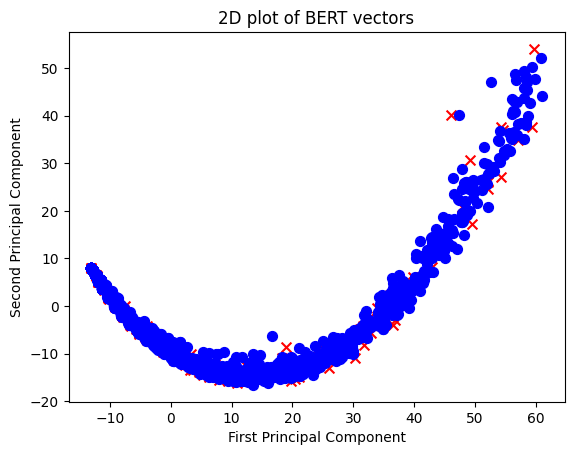

In [ ]:
# plot_vectors(text_vectors, labels, idx_test=idx_test, only_test_data=True)
plot_vectors(text_vectors, labels)

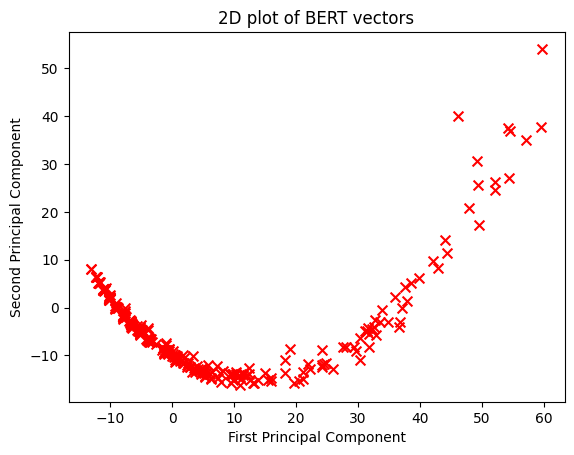

In [ ]:
def plot_vectors_class1(vectors, labels, title="2D plot of BERT vectors"):
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    # 散布図のプロット
    for idx, coord in enumerate(reduced_vectors):
        if labels[idx] == 1:
            plt.scatter(coord[0], coord[1], marker='x', s=50, c='r')

    plt.title(title)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.show()

plot_vectors_class1(text_vectors, labels)

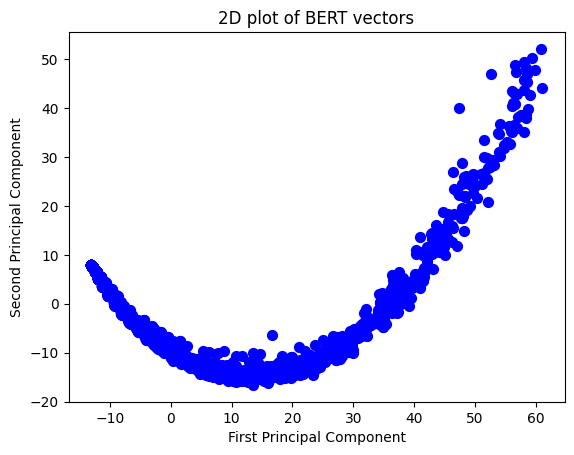

In [ ]:
def plot_vectors_class0(vectors, labels, title="2D plot of BERT vectors"):
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    # 散布図のプロット
    for idx, coord in enumerate(reduced_vectors):
        if labels[idx] == 0:
            plt.scatter(coord[0], coord[1], marker='o', s=50, c='b')

    plt.title(title)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.show()

plot_vectors_class0(text_vectors, labels)

In [ ]:
import pandas as pd

def display_list_as_table(input_list):
    data = {'インデックス': list(range(len(input_list))), '値': input_list}
    df = pd.DataFrame(data)
    display(df)

In [ ]:
display_list_as_table(texts_list)

,インデックス,値
0,0,"[os.system, requests.get]"
1,1,[requests.get]
2,2,[json.loads]
3,3,"[file.open, os.path]"
4,4,"[requests.get, file.open, exec]"
5,5,"[token, json.loads]"
6,6,[network.connect]
7,7,"[network.connect, os.system]"
8,8,"[sentence, read]"
9,9,"[client.get, file.save]"
